# Analysis of important features in the reconstruction



SOME STUFF

In [198]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import ultraplot as plot 

from typing import overload
import uproot
import mplhep as hep
import hist
import hist.intervals
import hist.plot

plot.rc['figure.facecolor'] = 'none'
plot.rc['savefig.facecolor'] = 'none'
plot.rc['legend.frameon'] = False
plot.rc['axes.autolimit_mode'] = 'data'

plot.rc['cmap.levels'] = 10

class Component:
    def __init__(self, data, tree_base='{}'):
        self.data = data
        self.tree_base = tree_base

    def get(self, stage1: str | list[str], product: str | list[str], binning, product_thr: float | list[float] = -100):

        if not isinstance(stage1, list):
            stage1 = [stage1]

        if not isinstance(product, list):
            product = [product]

        if not isinstance(product_thr, list):
            product_thr = [product_thr] * len(product)
        

        if not isinstance(binning, list) and len(product) > 1:
            binning = [binning] * len(product)
        
        data = []
        hists = []
    
        for e in stage1:
            data.append(self.data[self.tree_base.format(e)].arrays(library='pd'))

        
        d0 = data[0]
        common = d0
        for i in range(1, len(data)):
            d = data[i]
            common = pd.merge(
                d0[(d0[product] > product_thr).all(axis=1)][['event', *product]], 
                d[(d[product] > product_thr).all(axis=1)][['event', *product]], 
                on='event', suffixes=('', '_more')
            )
            # print(common.keys())
            d0 = common

        return_data = []
        for d in data:
            if len(product) == 1:
                hists.append(hist.Hist(binning).fill(d[d.event.isin(common.event)][product[0]].values))
            else:
                fill_data = [d[d.event.isin(common.event)][p].values for p in product]
                hists.append(hist.Hist(*binning).fill(*fill_data))
                return_data.append(d[d.event.isin(common.event)][['event', *product]])
            if False:
                print('ERROR: only 1D and 2D histograms are supported. The provided list of products exceed dimensionality: {}'.format(product))
            
        return hists, return_data
            
    def keys(self, stage1):
        return self.data[self.tree_base.format(stage1)].keys()


In [199]:

variables_1u1p = Component(uproot.open('2k_variables_1u1p.root:tests'))


In [200]:
variables_1u1p.get(['nominal', 'cheated_2D'], ['muon_purity', 'muon_completeness'], hist.axis.Regular(100, 0, 1))

([Hist(
    Regular(100, 0, 1, label='Axis 0'),
    Regular(100, 0, 1, label='Axis 0'),
    storage=Double()) # Sum: 2124.0 (2298.0 with flow),
  Hist(
    Regular(100, 0, 1, label='Axis 0'),
    Regular(100, 0, 1, label='Axis 0'),
    storage=Double()) # Sum: 1301.0 (2298.0 with flow)],
 [          event  muon_purity  muon_completeness
  102    312401.0     0.929302           0.960577
  147    221678.0     0.805233           0.717617
  159    221706.0     0.830317           0.993234
  165    266557.0     0.928854           0.963608
  254    310893.0     0.592593           0.996337
  ...         ...          ...                ...
  89994  464717.0     0.937036           0.966083
  90039  339145.0     0.930982           0.998355
  90061   13571.0     0.923560           0.998150
  90090   68031.0     0.868581           0.949572
  90199  365950.0     0.919175           0.999065
  
  [2298 rows x 3 columns],
            event  muon_purity  muon_completeness
  102    312401.0     0.937782 

In [201]:
variables_1u1p.keys('nominal')

['event',
 'dE',
 'reco_E',
 'true_E',
 'reco_pT',
 'vertex_difference',
 'vertex_difference_x',
 'vertex_difference_y',
 'vertex_difference_z',
 'muon_purity',
 'muon_completeness',
 'proton_purity',
 'proton_completeness',
 'pid_muon_L_reco_true_ratio',
 'pid_proton_L_reco_true_ratio',
 'pid_muon_P_reco_true_ratio',
 'pid_proton_P_reco_true_ratio',
 'pid_muon_true_L',
 'pid_muon_reco_L',
 'pid_muon_L_ratio_proxy',
 'pid_proton_true_L',
 'pid_proton_reco_L',
 'pid_muon_R',
 'pid_proton_R',
 'muon_momentum_rangeP',
 'proton_momentum_rangeP',
 'CT3D_rangeP',
 'CT3D_trueP']

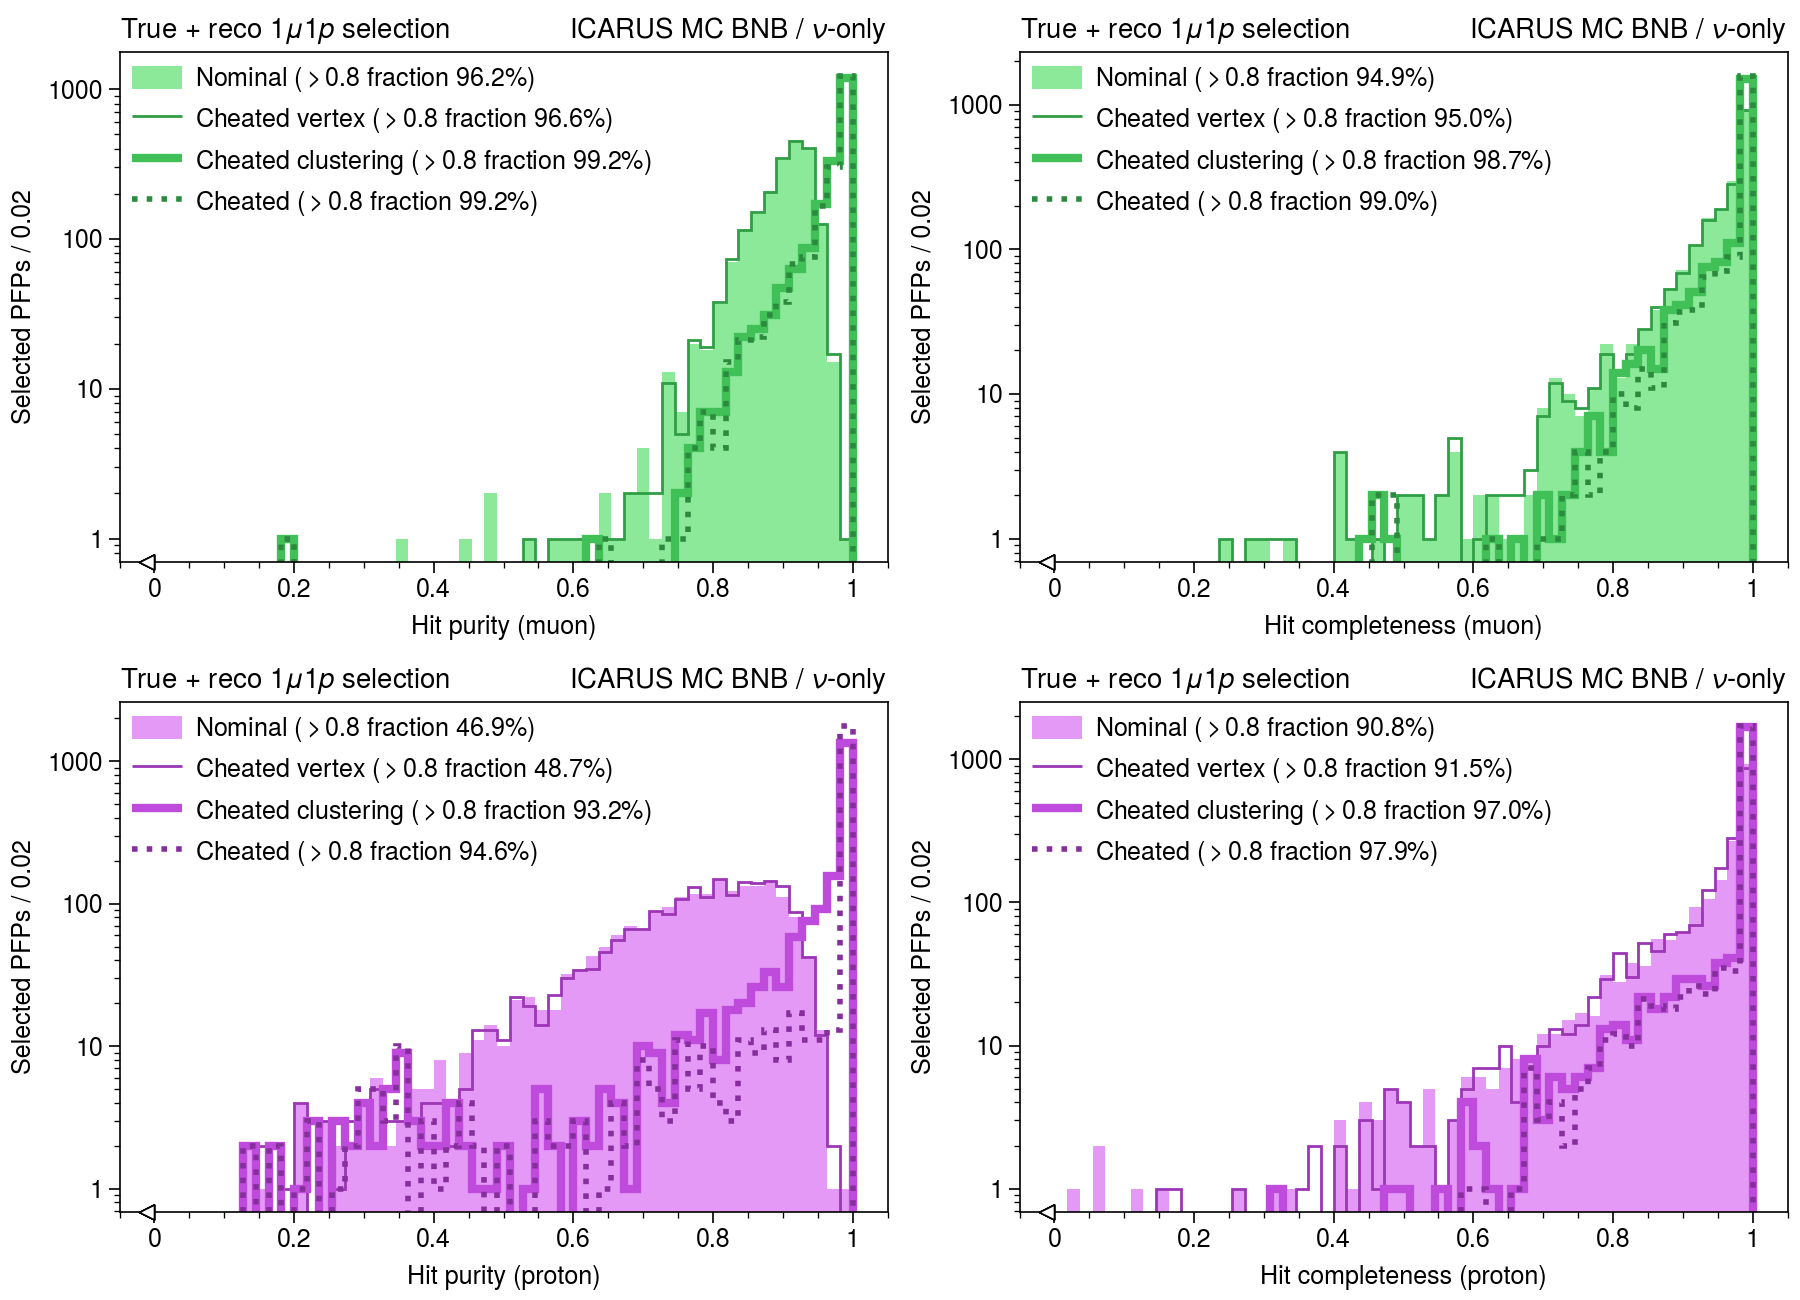

In [202]:
binning=hist.axis.Regular(55, 0, 1, overflow=False, name='hits')

fig, ax = plot.subplots(
    width=9, height=6.5, ncols=2, nrows=2, 
    xlabel=r'Hits', ylabel=f'Selected PFPs / {binning.widths[0]:.2f}',  
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    ltitle='True + reco $1\\mu1p$ selection',
    yscale='log'
)

A_colors = {
    'muon': 'green3',
    'proton': 'grape3'
}


B_colors = {
    'muon': 'green6',
    'proton': 'grape6'
}

C_colors = {
    'muon': 'green8',
    'proton': 'grape8'
}

D_colors = {
    'muon': 'green9',
    'proton': 'grape9'
}


for idx_p, particle in enumerate(['muon', 'proton']):
    for idx_l, label in enumerate(['purity', 'completeness']):
        (A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], f'{particle}_{label}', binning=binning)
        hep.histplot(A, ax=ax[idx_p, idx_l], density=False, yerr=False, label=f'Nominal ($>0.8$ fraction {A[hist.loc(0.8):hist.loc(1.1)].counts().sum()/A.counts().sum():.1%})', histtype='fill', color=A_colors[particle])
        hep.histplot(C, ax=ax[idx_p, idx_l], density=False, yerr=False, label=f'Cheated vertex ($>0.8$ fraction {C[hist.loc(0.8):hist.loc(1.1)].counts().sum()/C.counts().sum():.1%})', color=C_colors[particle], lw=1)
        hep.histplot(B, ax=ax[idx_p, idx_l], density=False, yerr=False, label=f'Cheated clustering ($>0.8$ fraction {B[hist.loc(0.8):hist.loc(1.1)].counts().sum()/B.counts().sum():.1%})', color=B_colors[particle], lw=3)
        hep.histplot(D, ax=ax[idx_p, idx_l], density=False, yerr=False, label=f'Cheated ($>0.8$ fraction {D[hist.loc(0.8):hist.loc(1.1)].counts().sum()/D.counts().sum():.1%})', color=D_colors[particle], lw=2, ls=':')
        ax[idx_p, idx_l].format(
            xlabel=f'Hit {label} ({particle})',
        )
        ax[idx_p, idx_l].legend(ncols=1, loc='ul')


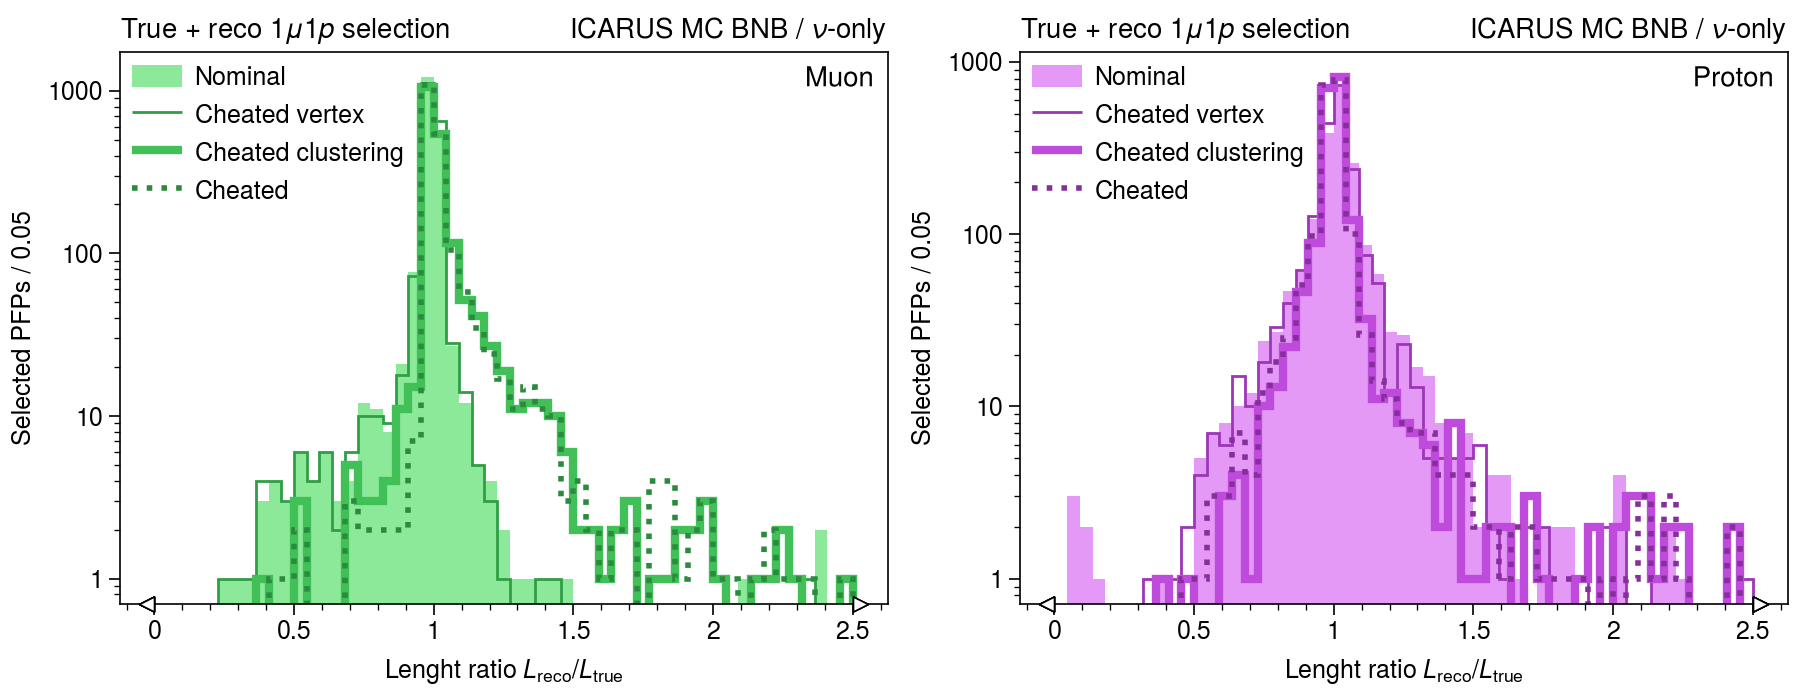

In [262]:
binning=hist.axis.Regular(55, 0, 2.5)

fig, axs = plot.subplots(
    width=9, height=3.5, ncols=2, nrows=1, 
    xlabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$', ylabel=f'Selected PFPs / {binning.widths[0]:.2f}',  
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    ltitle='True + reco $1\\mu1p$ selection',
    yscale='log'
)

label_dict = {
    'muon': 'Muon',
    'proton': 'Proton'
}

A_colors = {
    'muon': 'green3',
    'proton': 'grape3'
}


B_colors = {
    'muon': 'green6',
    'proton': 'grape6'
}

C_colors = {
    'muon': 'green8',
    'proton': 'grape8'
}

D_colors = {
    'muon': 'green9',
    'proton': 'grape9'
}

for ax, particle in zip(axs, ['muon', 'proton']):
    (A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], f'pid_{particle}_L_reco_true_ratio', binning=binning)
    hep.histplot(A, ax=ax, density=False, yerr=False, label=f'Nominal', histtype='fill', color=A_colors[particle])
    hep.histplot(C, ax=ax, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
    hep.histplot(B, ax=ax, density=False, yerr=False, label=f'Cheated clustering', color=B_colors[particle], lw=3)
    hep.histplot(D, ax=ax, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')
    ax.format(urtitle=label_dict[particle])
    ax.legend(ncols=1, loc='ul')

A_colors['muon'] = 'orange3'
C_colors['muon'] = 'orange8'
B_colors['muon'] = 'orange6'
D_colors['muon'] = 'orange9'

# for ax, particle in zip(axs, ['muon']):
#     (A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], f'pid_{particle}_L_ratio_proxy', binning=binning)
#     hep.histplot(A, ax=ax, density=False, yerr=False, alpha=0.5, label=f'Nominal (end-start difference)', histtype='fill', hatch='////', color=A_colors[particle])
#     hep.histplot(C, ax=ax, density=False, yerr=False, alpha=0.5, label=f'Cheated vertex (end-start difference)', color=C_colors[particle], lw=1)
#     hep.histplot(B, ax=ax, density=False, yerr=False, alpha=0.5, label=f'Cheated clustering (end-start difference)', color=B_colors[particle], lw=3)
#     hep.histplot(D, ax=ax, density=False, yerr=False, alpha=0.5, label=f'Cheated (end-start difference)', color=D_colors[particle], lw=2, ls=':')
#     ax.format(urtitle=label_dict[particle])
#     ax.legend(ncols=1, loc='ul')


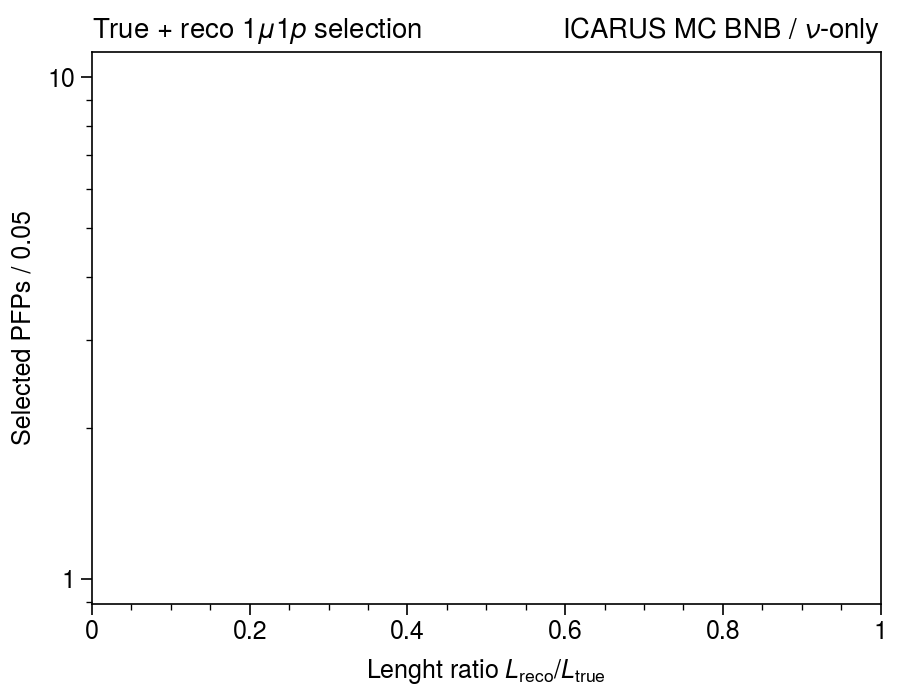

In [204]:
binning=hist.axis.Regular(55, 0, 2.5)

fig, axs = plot.subplots(
    width=4.5, height=3.5, ncols=1, nrows=1, 
    xlabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$', ylabel=f'Selected PFPs / {binning.widths[0]:.2f}',  
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    ltitle='True + reco $1\\mu1p$ selection',
    yscale='log'
)

label_dict = {
    'muon': 'Muon',
    'proton': 'Proton'
}




In [229]:
_, (a,b) = variables_1u1p.get(['nominal', 'cheated_2D'], ['pid_muon_L_reco_true_ratio', 'pid_muon_L_ratio_proxy'], binning=binning)

a[a.pid_muon_L_reco_true_ratio>1.15].sort_values('event')

,event,pid_muon_L_reco_true_ratio,pid_muon_L_ratio_proxy
35827,23686.0,1.215427,1.210107
39478,26367.0,1.183913,0.988258
15580,44453.0,2.403058,2.240946
77787,45952.0,1.151793,1.144568
17788,50973.0,1.160285,1.052929
17486,119447.0,1.202544,1.044091
3718,259192.0,1.242390,1.227726
83572,262182.0,1.448420,1.320117
42066,302121.0,1.312229,1.228012
63437,302392.0,1.183408,0.990199


In [228]:
b[(b.pid_muon_L_reco_true_ratio>1.15) & b.event.isin(a[a.pid_muon_L_reco_true_ratio>1.15].event)].sort_values('event')

,event,pid_muon_L_reco_true_ratio,pid_muon_L_ratio_proxy
35827,23686.0,1.415094,1.369009
39478,26367.0,1.158502,1.094253
77787,45952.0,1.182283,1.174229
17788,50973.0,1.353098,1.140508
17486,119447.0,1.241786,0.986583
83572,262182.0,1.846125,1.588110
42066,302121.0,1.406324,1.321357


In [233]:
b[(b.pid_muon_L_reco_true_ratio>1.5) & b.event.isin(a[a.pid_muon_L_reco_true_ratio<1.].event)].sort_values('event')

,event,pid_muon_L_reco_true_ratio,pid_muon_L_ratio_proxy
89947,2749.0,100.645157,98.369848
65870,4143.0,1.810918,1.619600
53216,21155.0,1.876345,1.223787
34361,23091.0,2.897270,1.529469
55418,23416.0,2.206551,1.800507
58351,25827.0,2.900512,1.229572
30724,50745.0,1.753780,1.244742
17777,50952.0,3.709602,2.982580
17499,119468.0,1.878267,1.436978
4917,140973.0,3.965948,3.286855


In [250]:
both = pd.merge(a, b, on='event', suffixes=('_nominal', '_2Dc'))
both[(both.pid_muon_L_reco_true_ratio_2Dc>1.5) & (both.pid_muon_L_reco_true_ratio_nominal<1.)].sort_values('event')

,event,pid_muon_L_reco_true_ratio_nominal,pid_muon_L_ratio_proxy_nominal,pid_muon_L_reco_true_ratio_2Dc,pid_muon_L_ratio_proxy_2Dc
2297,2749.0,0.997516,0.995204,100.645157,98.369848
1647,4143.0,0.993151,0.988455,1.810918,1.619600
1347,21155.0,0.925228,0.913306,1.876345,1.223787
854,23091.0,0.991139,0.985912,2.897270,1.529469
1394,23416.0,0.978281,0.965074,2.206551,1.800507
1457,25827.0,0.984848,0.972264,2.900512,1.229572
756,50745.0,0.990330,0.988151,1.753780,1.244742
433,50952.0,0.986386,0.981548,3.709602,2.982580
425,119468.0,0.989249,0.982001,1.878267,1.436978
97,140973.0,0.980524,0.977919,3.965948,3.286855


In [259]:
_, (a,b) = variables_1u1p.get(['nominal', 'cheated_2D'], ['pid_muon_L_reco_true_ratio', 'pid_muon_true_L', 'pid_muon_reco_L', 'pid_muon_L_ratio_proxy'], binning=binning)
both = pd.merge(a, b, on='event', suffixes=('_nominal', '_2Dc'))
selected = both[(both.pid_muon_L_reco_true_ratio_2Dc>1.5) & (both.pid_muon_L_reco_true_ratio_nominal<1.)].sort_values('event')
selected[selected.pid_muon_true_L_nominal>150]

,event,pid_muon_L_reco_true_ratio_nominal,pid_muon_true_L_nominal,pid_muon_reco_L_nominal,pid_muon_L_ratio_proxy_nominal,pid_muon_L_reco_true_ratio_2Dc,pid_muon_true_L_2Dc,pid_muon_reco_L_2Dc,pid_muon_L_ratio_proxy_2Dc
854,23091.0,0.991139,255.840866,253.573898,0.985912,2.897270,255.840866,741.239990,1.529469
756,50745.0,0.990330,180.131149,178.389282,0.988151,1.753780,180.131149,315.910492,1.244742
404,165488.0,0.997799,160.317429,159.964615,0.995627,2.707901,160.317429,434.123749,2.064114
599,173400.0,0.993967,151.179626,150.267548,0.992814,1.916069,151.179626,289.670624,1.752314
883,256250.0,0.996112,321.201324,319.952576,0.988431,2.302163,321.201324,739.457825,1.915795
1228,258076.0,0.995417,250.441727,249.293976,0.989546,1.595584,250.441727,399.600739,1.383352
1098,260959.0,0.999388,304.656189,304.469635,0.989425,1.533990,304.656189,467.339569,1.080372
197,300174.0,0.997531,353.784851,352.911346,0.994875,1.970667,353.784851,697.192322,1.490534
1796,358150.0,0.994859,404.663910,402.583344,0.990768,1.983126,404.663910,802.499634,1.656489
1205,366414.0,0.736488,338.854065,249.561890,0.729920,1.567544,338.854065,531.168518,1.104301


In [258]:
both[both.event == 262182]

,event,pid_muon_L_reco_true_ratio_nominal,pid_muon_true_L_nominal,pid_muon_reco_L_nominal,pid_muon_L_ratio_proxy_nominal,pid_muon_L_reco_true_ratio_2Dc,pid_muon_true_L_2Dc,pid_muon_reco_L_2Dc,pid_muon_L_ratio_proxy_2Dc
2118,262182.0,1.44842,54.883137,79.49382,1.320117,1.846125,54.883137,101.321144,1.58811


In [260]:
both[both.event == 366414]

,event,pid_muon_L_reco_true_ratio_nominal,pid_muon_true_L_nominal,pid_muon_reco_L_nominal,pid_muon_L_ratio_proxy_nominal,pid_muon_L_reco_true_ratio_2Dc,pid_muon_true_L_2Dc,pid_muon_reco_L_2Dc,pid_muon_L_ratio_proxy_2Dc
1205,366414.0,0.736488,338.854065,249.56189,0.72992,1.567544,338.854065,531.168518,1.104301


In [261]:
both[both.event == 260959]

,event,pid_muon_L_reco_true_ratio_nominal,pid_muon_true_L_nominal,pid_muon_reco_L_nominal,pid_muon_L_ratio_proxy_nominal,pid_muon_L_reco_true_ratio_2Dc,pid_muon_true_L_2Dc,pid_muon_reco_L_2Dc,pid_muon_L_ratio_proxy_2Dc
1098,260959.0,0.999388,304.656189,304.469635,0.989425,1.53399,304.656189,467.339569,1.080372


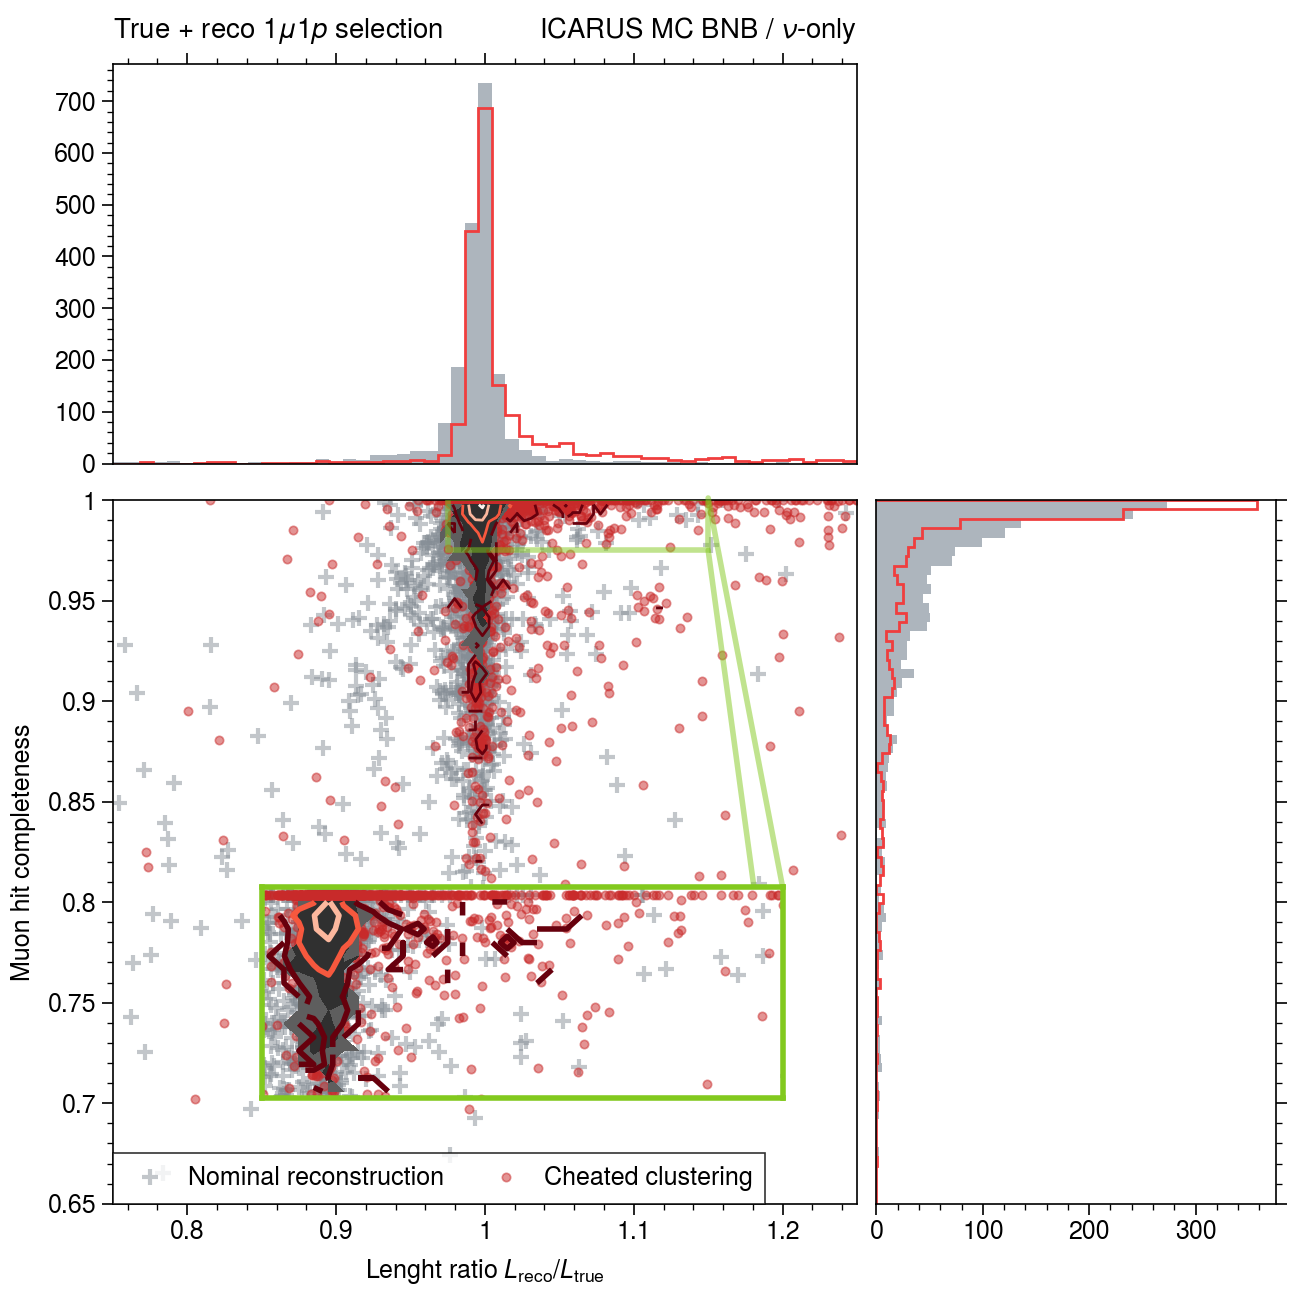

In [206]:
binning=[hist.axis.Regular(75, 0.8, 1.15), hist.axis.Regular(75, 0.65, 1)] # ratio, hit completeness
plot.rc['cmap.levels'] = 6

fig, ax = plot.subplots(
    width=6.5, height=6.5, ncols=1, nrows=1, 
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only',
    ltitle='True + reco $1\\mu1p$ selection',
    # yscale='log'
)

(a, b, c), (A, B, C) = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx'], ['pid_muon_L_reco_true_ratio', 'muon_completeness'], binning=binning)

A = A[(A.pid_muon_L_reco_true_ratio>0) & (A.muon_completeness>0)]
B = B[(B.pid_muon_L_reco_true_ratio>0) & (B.muon_completeness>0)]

ax=ax[0]
ax.scatter(A.pid_muon_L_reco_true_ratio, A.muon_completeness, color='gray6', alpha=0.5, marker='+', label='Nominal reconstruction')
ax.scatter(B.pid_muon_L_reco_true_ratio, B.muon_completeness, color='red9', alpha=0.5, marker='.', label='Cheated clustering')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ax.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H <= 0, H)
ax.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), alpha=1, lw=1, label=r'Cheated clustering')

ix = ax.inset_axes((0.2, 0.15, 0.7, 0.3), transform='axes')

(a, b, c), (A, B, C) = variables_1u1p.get(
    ['nominal', 'cheated_2D', 'cheated_Vtx'], ['pid_muon_L_reco_true_ratio', 'muon_completeness'], 
    binning=[hist.axis.Regular(35, 0.975, 1.15), hist.axis.Regular(15, 0.975, 1)]
)

A = A[(A.pid_muon_L_reco_true_ratio>0) & (A.muon_completeness>0)]
B = B[(B.pid_muon_L_reco_true_ratio>0) & (B.muon_completeness>0)]

ix.scatter(A.pid_muon_L_reco_true_ratio, A.muon_completeness, color='gray6', alpha=0.5, marker='+', label='')
ix.scatter(B.pid_muon_L_reco_true_ratio, B.muon_completeness, color='red9', alpha=0.5, marker='.', label='')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ix.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.2, vmax=2*H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H <= 0, H)
ix.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=2*H.max(), alpha=1, lw=2)

ix.format(
    xlabel='', ylabel='', xlim=(0.975, 1.15), ylim=(0.975, 1.001),
    xticks=[], yticks=[], color='lime6', lw=2
)

ix.indicate_inset_zoom(lw=2, ec='lime6')

top = ax.panel(side='t', width=2)

(A, B, C, D), _ = variables_1u1p.get(
    ['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 
    'pid_muon_L_reco_true_ratio', binning=hist.axis.Regular(55, 0.75, 1.25, flow=False)
)
hep.histplot(A, ax=top, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5')
hep.histplot(B, ax=top, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1)

right = ax.panel(side='r', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 'muon_completeness', binning=hist.axis.Regular(75, 0.65, 1))
hep.histplot(A.to_numpy(), ax=right, density=False, yerr=False, histtype='fill', color='gray5', orientation='horizontal')
hep.histplot(B.to_numpy(), ax=right, density=False, yerr=False, color='red7', lw=1, orientation='horizontal')


right.format(
    xlabel=r'', ylabel='', ylim=(0.65, 1), grid=False
)
top.format(
    xlabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$', ylabel='', xlim=(0.75, 1.25), grid=False
)
ax.format(
    xlabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$', ylabel='Muon hit completeness',  
    xlim=(0.75, 1.25), ylim=(0.65, 1)
)
ax.legend(ncols=2, loc='ll', frameon=True)

fig.savefig('2k_lenght_ratio_vs_µ_completeness.pdf', bbox_inches='tight')

np.float64(17.0)

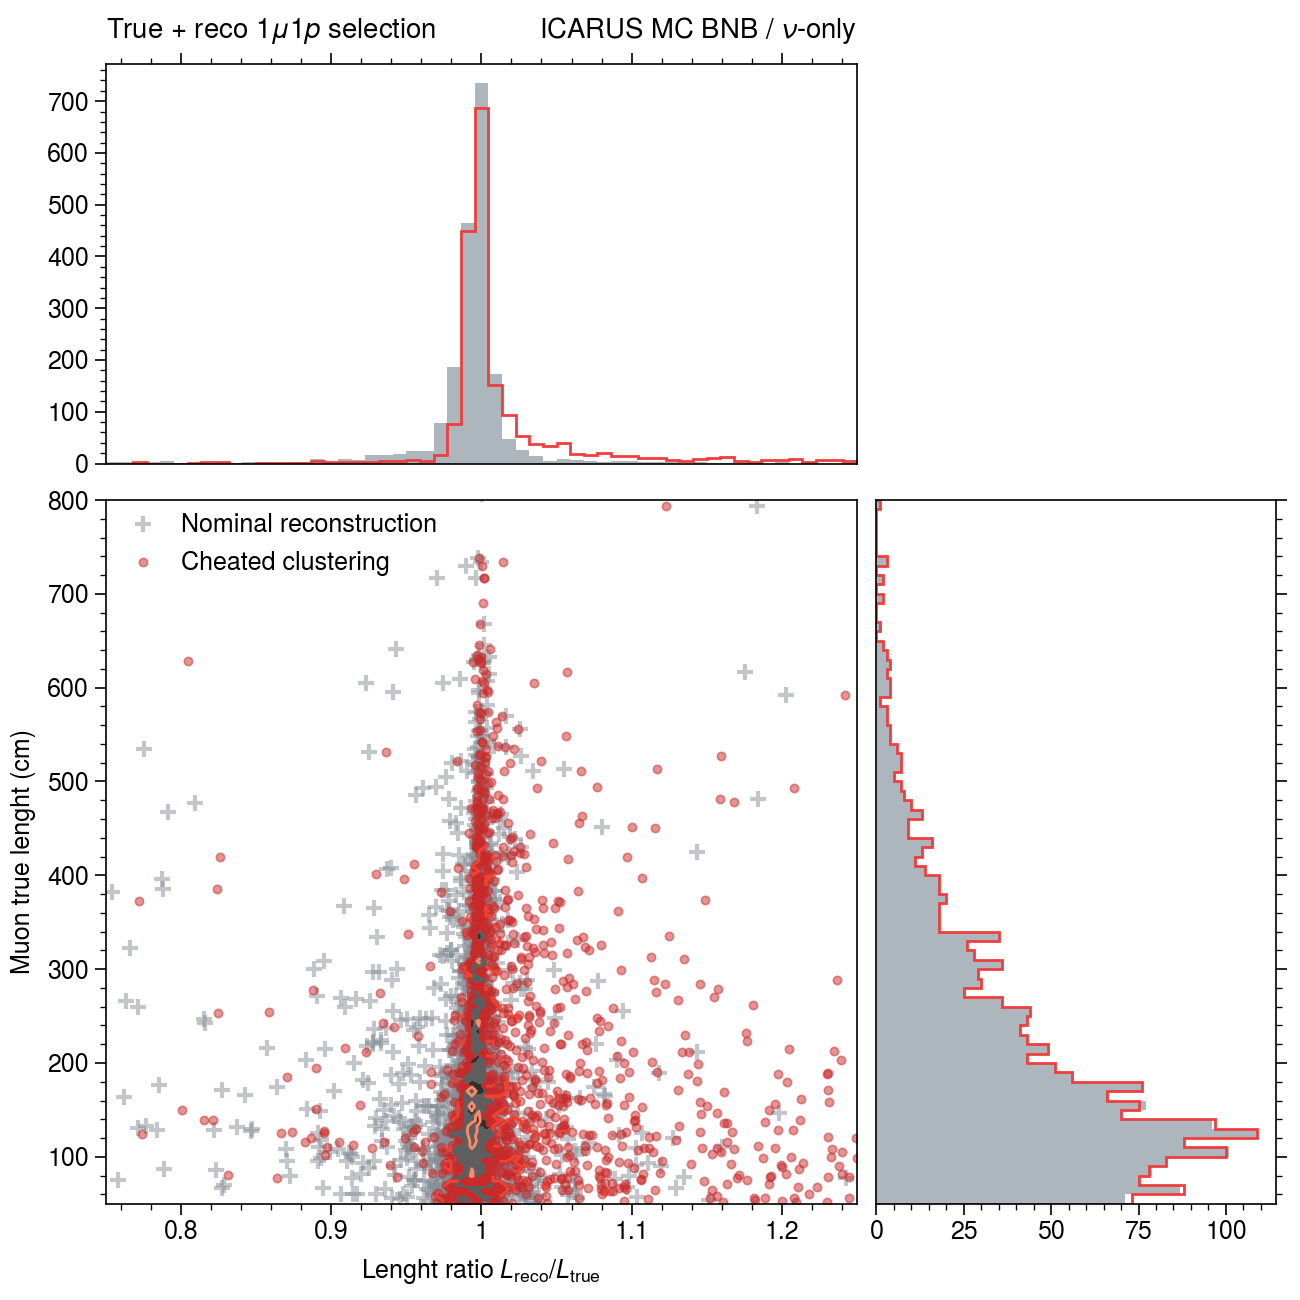

In [207]:
binning=[hist.axis.Regular(75, 0.8, 1.15), hist.axis.Regular(75, 50, 450)] # ratio, lenght
plot.rc['cmap.levels'] = 6

fig, axs = plot.subplots(
    width=6.5, height=6.5, ncols=1, nrows=1, 
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only',
    ltitle='True + reco $1\\mu1p$ selection',
    # yscale='log'
)

(a, b, c), (A, B, C) = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx'], ['pid_muon_L_reco_true_ratio', 'pid_muon_true_L'], binning=binning)

ax = axs[0]
A = A[A.pid_muon_L_reco_true_ratio>0]
B = B[B.pid_muon_L_reco_true_ratio>0]



ax.scatter(A.pid_muon_L_reco_true_ratio, A.pid_muon_true_L, color='gray6', alpha=0.5, marker='+', label='Nominal reconstruction')
ax.scatter(B.pid_muon_L_reco_true_ratio, B.pid_muon_true_L, color='red9', alpha=0.5, marker='.', label='Cheated clustering')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ax.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H <= 0, H)
ax.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), alpha=1, lw=1, label='Cheated clustering')


top = ax.panel(side='t', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 'pid_muon_L_reco_true_ratio', binning=hist.axis.Regular(55, 0.75, 1.25, flow=False))
hep.histplot(A, ax=top, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5')
# hep.histplot(C, ax=top, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
hep.histplot(B, ax=top, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1)
# hep.histplot(D, ax=top, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')

right = ax.panel(side='r', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 'pid_muon_true_L', binning=hist.axis.Regular(75, 50, 800))
hep.histplot(A.to_numpy(), ax=right, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5', orientation='horizontal')
# hep.histplot(C, ax=top, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
hep.histplot(B.to_numpy(), ax=right, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1, orientation='horizontal')
# hep.histplot(D, ax=top, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')


right.format(
    xlabel=r'', ylabel='', ylim=(50, 800), grid=False
)
top.format(
    xlabel=r'', ylabel='', xlim=(0.75, 1.25), grid=False
)
ax.format(
    xlabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$', ylabel='Muon true lenght (cm)',  
    xlim=(0.75, 1.25), ylim=(50, 800)
)
ax.legend(ncols=1)

H.max()

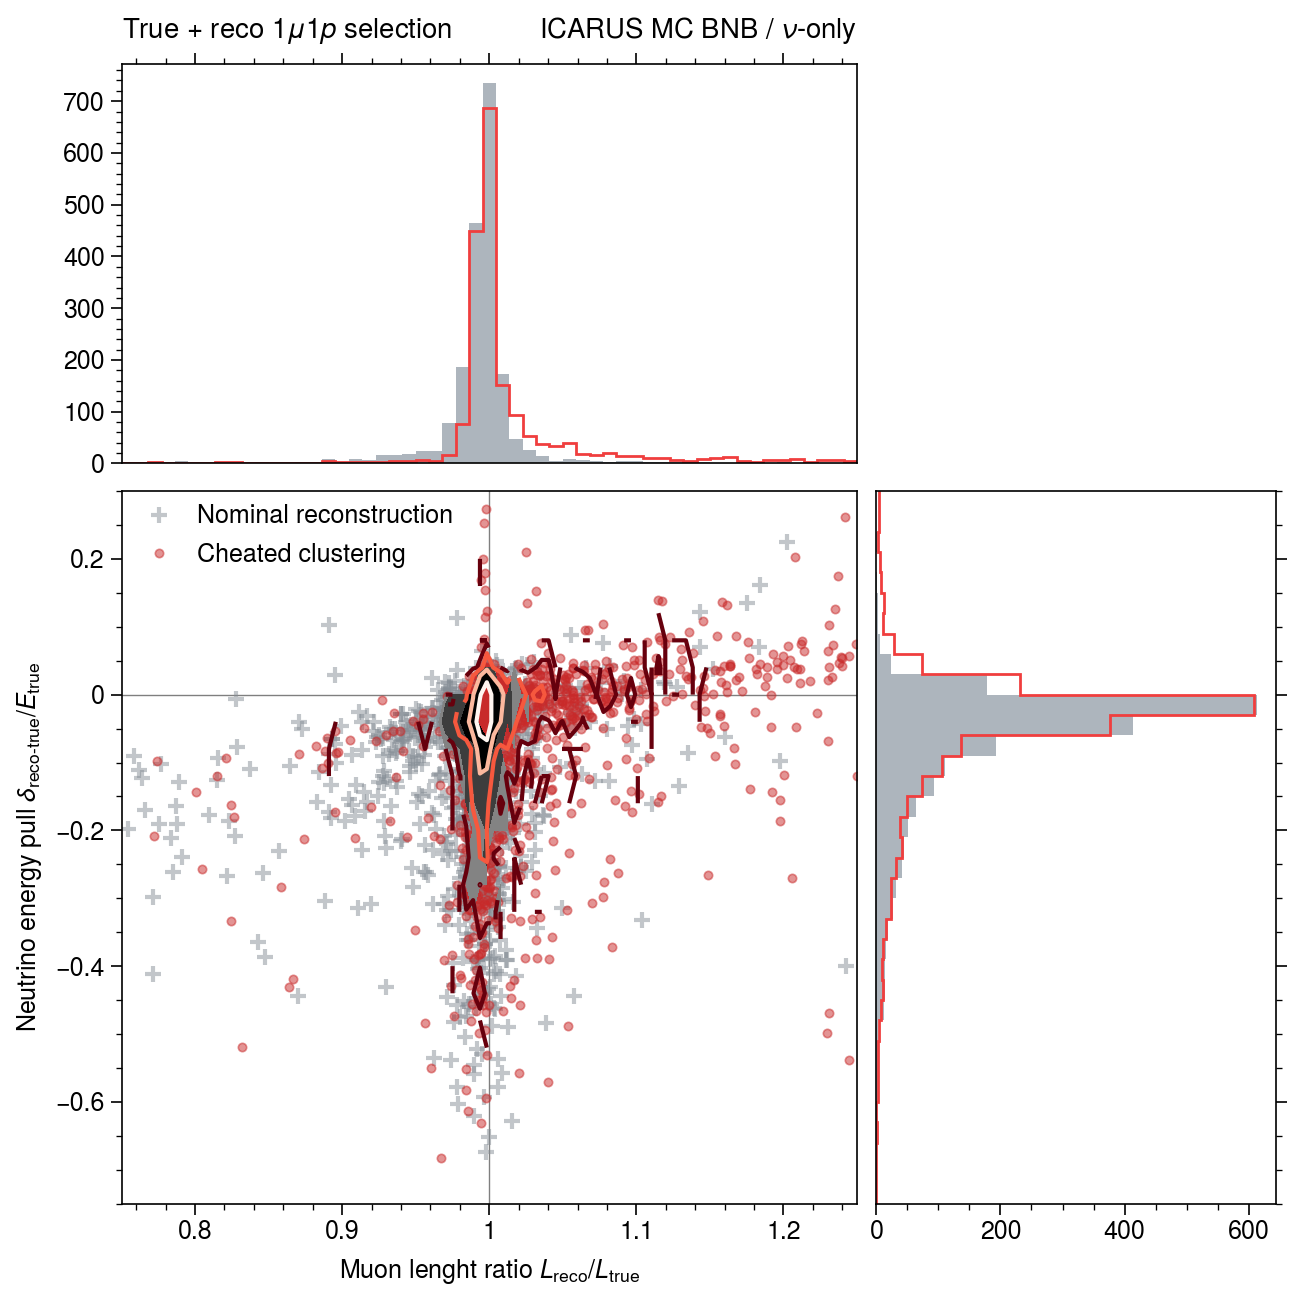

In [208]:
binning=[hist.axis.Regular(75, 0.8, 1.15), hist.axis.Regular(75, -1.5, 1.5)] # ratio, E pull
plot.rc['cmap.levels'] = 6

fig, axs = plot.subplots(
    width=6.5, height=6.5, ncols=1, nrows=1, 
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only',
    ltitle='True + reco $1\\mu1p$ selection',
    # yscale='log'
)

(a, b, c), (A, B, C) = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx'], ['pid_muon_L_reco_true_ratio', 'dE'], binning=binning)

ax = axs[0]
A = A[A.pid_muon_L_reco_true_ratio>0]
B = B[B.pid_muon_L_reco_true_ratio>0]



ax.scatter(A.pid_muon_L_reco_true_ratio, A.dE, color='gray6', alpha=0.5, marker='+', label='Nominal reconstruction')
ax.scatter(B.pid_muon_L_reco_true_ratio, B.dE, color='red9', alpha=0.5, marker='.', label='Cheated clustering')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ax.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H <= 0, H)
ax.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), alpha=1, lw=1.5, label='Cheated clustering')


top = ax.panel(side='t', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 'pid_muon_L_reco_true_ratio', binning=hist.axis.Regular(55, 0.75, 1.25, flow=False))
hep.histplot(A, ax=top, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5')
# hep.histplot(C, ax=top, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
hep.histplot(B, ax=top, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1)
# hep.histplot(D, ax=top, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')

right = ax.panel(side='r', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 'dE', binning=hist.axis.Regular(100,  -1.5, 1.5))
hep.histplot(A.to_numpy(), ax=right, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5', orientation='horizontal')
# hep.histplot(C, ax=top, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
hep.histplot(B.to_numpy(), ax=right, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1, orientation='horizontal')
# hep.histplot(D, ax=top, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')


right.format(
    xlabel=r'', ylabel='', ylim=(-.75, .3), grid=False
)
top.format(
    xlabel=r'', ylabel='', xlim=(0.75, 1.25), grid=False
)
ax.format(
    xlabel=r'Muon lenght ratio $L_\text{reco}/L_\text{true}$', ylabel=r'Neutrino energy pull $\delta_\text{reco-true}/E_\text{true}$',  
    xlim=(0.75, 1.25), ylim=(-.75, .3)
)
ax.legend(ncols=1)

ax.axhline(0, color='k', lw=0.5, alpha=0.5, zorder=-99)
ax.axvline(1, color='k', lw=0.5, alpha=0.5, zorder=-99)

H.max()

fig.savefig('2k_length_ratio_vs_energy_pull.pdf', bbox_inches='tight')

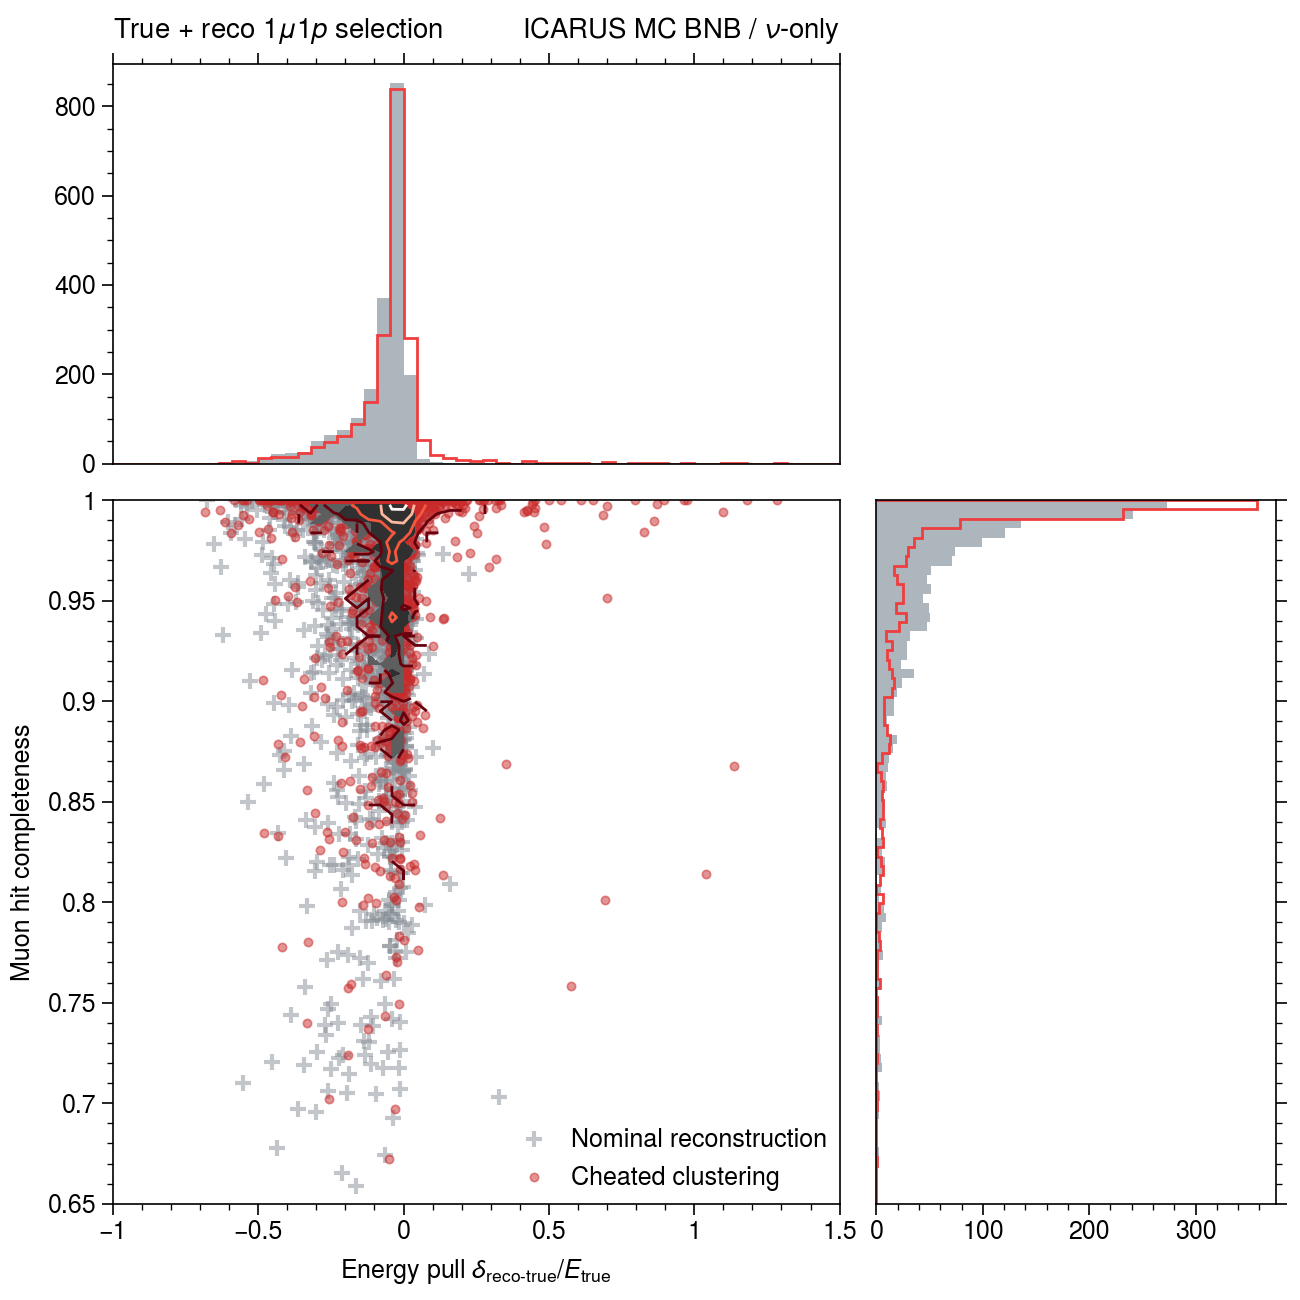

In [209]:
binning=[hist.axis.Regular(75, -1.5, 1.5), hist.axis.Regular(75, 0.65, 1)] # ratio, hit completeness
plot.rc['cmap.levels'] = 6

fig, axs = plot.subplots(
    width=6.5, height=6.5, ncols=1, nrows=1, 
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only',
    ltitle='True + reco $1\\mu1p$ selection',
    # yscale='log'
)

(a, b, c), (A, B, C) = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx'], ['dE', 'muon_completeness'], binning=binning)

ax = axs[0]
A = A[(A.dE>-100) & (A.muon_completeness>0)]
B = B[(B.dE>-100) & (B.muon_completeness>0)]



ax.scatter(A.dE, A.muon_completeness, color='gray6', alpha=0.5, marker='+', label='Nominal reconstruction')
ax.scatter(B.dE, B.muon_completeness, color='red9', alpha=0.5, marker='.', label='Cheated clustering')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ax.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H <= 0, H)
ax.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), alpha=1, lw=1, label='Cheated clustering')


top = ax.panel(side='t', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 'dE', binning=hist.axis.Regular(55, -1., 1.5, flow=False))
hep.histplot(A, ax=top, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5')
hep.histplot(B, ax=top, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1)

right = ax.panel(side='r', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 'muon_completeness', binning=hist.axis.Regular(75, 0.65, 1))
hep.histplot(A.to_numpy(), ax=right, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5', orientation='horizontal')
hep.histplot(B.to_numpy(), ax=right, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1, orientation='horizontal')


right.format(
    xlabel=r'', ylabel='', ylim=(0.65, 1), grid=False
)
top.format(
    xlabel=r'', ylabel='', xlim=(-1., 1.5), grid=False
)
ax.format(
    xlabel=r'Energy pull $\delta_\text{reco-true}/E_\text{true}$', ylabel='Muon hit completeness',  
    xlim=(-1., 1.5), ylim=(0.65, 1)
)
ax.legend(ncols=1)

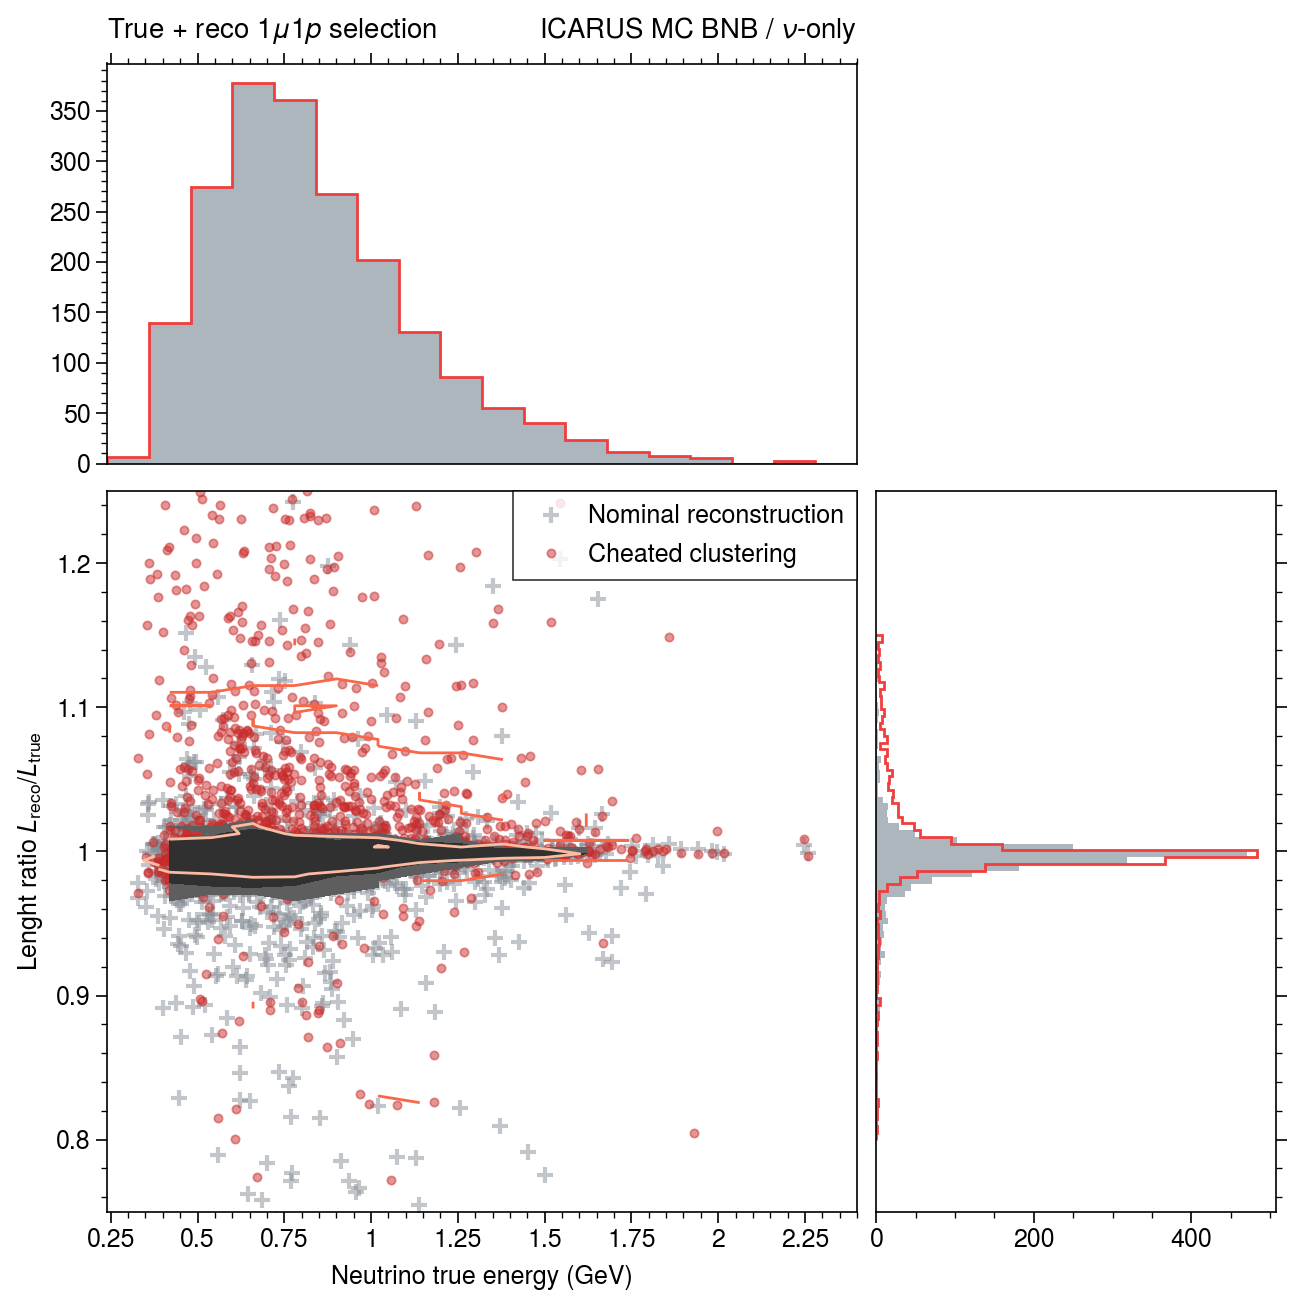

In [210]:
binning=[hist.axis.Regular(18, 0.24, 2.4), hist.axis.Regular(75, 0.8, 1.15)] # ratio, hit completeness
plot.rc['cmap.levels'] = 6

fig, axs = plot.subplots(
    width=6.5, height=6.5, ncols=1, nrows=1, 
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only',
    ltitle='True + reco $1\\mu1p$ selection',
    # yscale='log'
)

(a, b, c), (A, B, C) = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx'], ['true_E', 'pid_muon_L_reco_true_ratio'], binning=binning)

ax = axs[0]
A = A[(A.true_E>-100) & (A.pid_muon_L_reco_true_ratio>0)]
B = B[(B.true_E>-100) & (B.pid_muon_L_reco_true_ratio>0)]



ax.scatter(A.true_E, A.pid_muon_L_reco_true_ratio, color='gray6', alpha=0.5, marker='+', label='Nominal reconstruction')
ax.scatter(B.true_E, B.pid_muon_L_reco_true_ratio, color='red9', alpha=0.5, marker='.', label='Cheated clustering')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ax.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H < 0.1, H)
ax.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=0.1*H.max(), alpha=1, lw=1, label='Cheated clustering')


top = ax.panel(side='t', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 'true_E', binning=hist.axis.Regular(18, 0.24, 2.4, flow=False))
hep.histplot(A, ax=top, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5')
hep.histplot(B, ax=top, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1)

right = ax.panel(side='r', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 'pid_muon_L_reco_true_ratio', binning=hist.axis.Regular(75, 0.8, 1.15))
hep.histplot(A.to_numpy(), ax=right, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5', orientation='horizontal')
hep.histplot(B.to_numpy(), ax=right, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1, orientation='horizontal')


right.format(
    xlabel=r'', ylabel='', ylim=(0.75, 1.25), grid=False
)
top.format(
    xlabel=r'', ylabel='', xlim=(0.24, 2.4), grid=False
)
ax.format(
    xlabel=r'Neutrino true energy (GeV)', ylabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$',  
    xlim=(0.24, 2.4), ylim=(0.75, 1.25)
)
ax.legend(ncols=1, frameon=True)

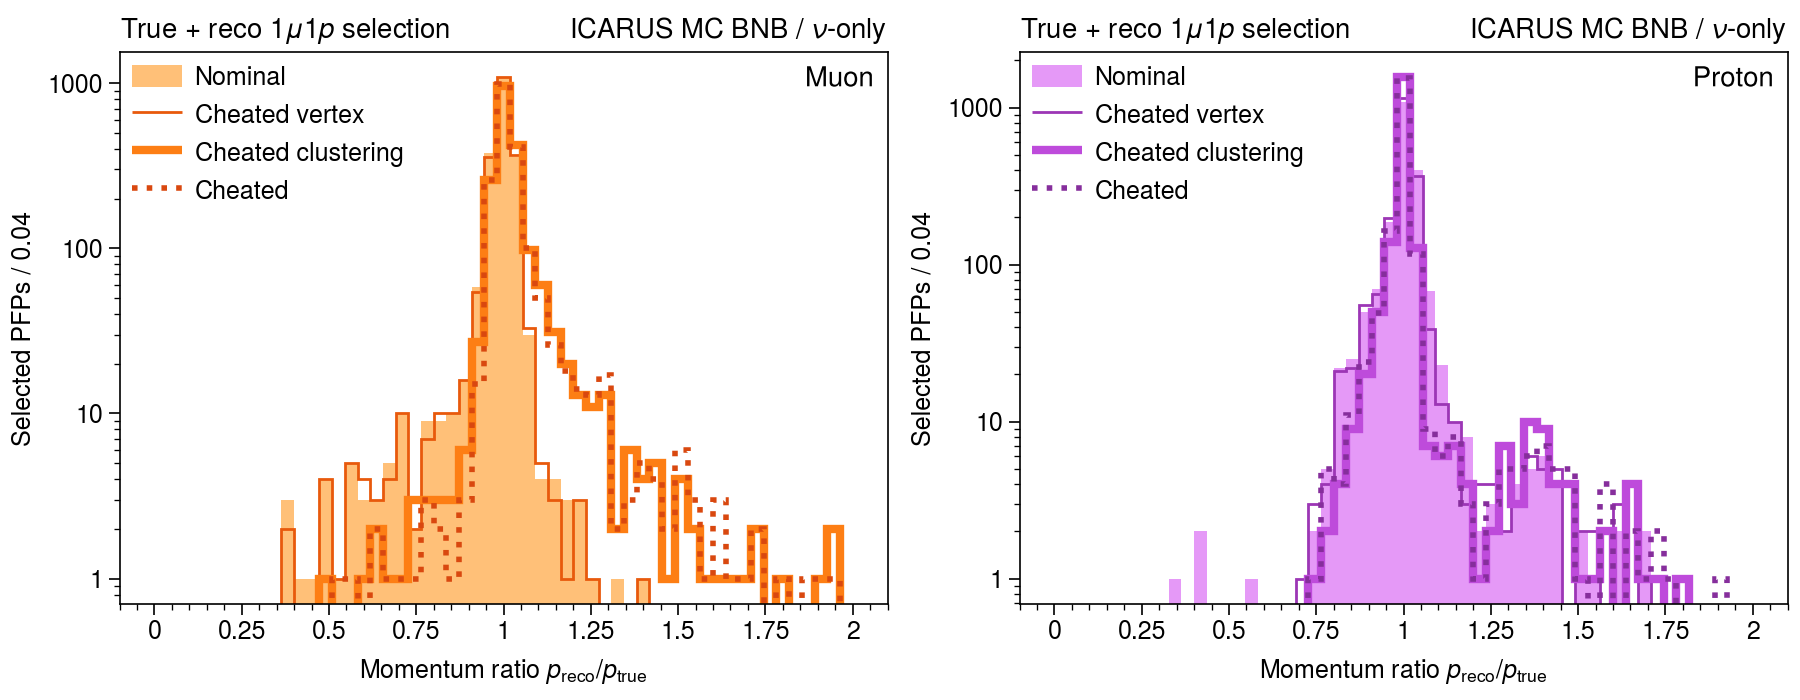

In [211]:
binning=hist.axis.Regular(55, 0, 2, flow=False)

fig, axs = plot.subplots(
    width=9, height=3.5, ncols=2, nrows=1, 
    xlabel=r'Momentum ratio $p_\text{reco}/p_\text{true}$', ylabel=f'Selected PFPs / {binning.widths[0]:.2f}',  
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    ltitle='True + reco $1\\mu1p$ selection',
    yscale='log'
)

label_dict = {
    'muon': 'Muon',
    'proton': 'Proton'
}

for ax, particle in zip(axs, ['muon', 'proton']):
    (A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], f'pid_{particle}_P_reco_true_ratio', binning=binning)
    hep.histplot(A, ax=ax, density=False, yerr=False, label=f'Nominal', histtype='fill', color=A_colors[particle])
    hep.histplot(C, ax=ax, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
    hep.histplot(B, ax=ax, density=False, yerr=False, label=f'Cheated clustering', color=B_colors[particle], lw=3)
    hep.histplot(D, ax=ax, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')
    ax.format(urtitle=label_dict[particle])
    ax.legend(ncols=1, loc='ul')


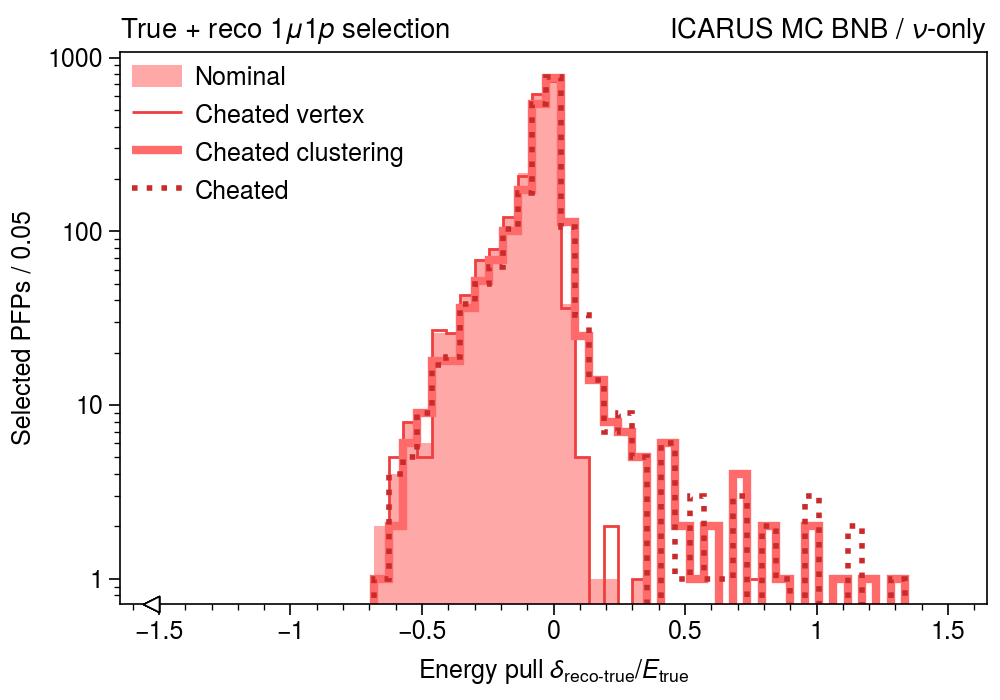

In [212]:
binning=hist.axis.Regular(55, -1.5, 1.5, overflow=False)

fig, ax = plot.subplots(
    width=5, height=3.5, ncols=1, nrows=1, 
    xlabel=r'Energy pull $\delta_\text{reco-true}/E_\text{true}$', ylabel=f'Selected PFPs / {binning.widths[0]:.2f}',  
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    ltitle='True + reco $1\\mu1p$ selection',
    yscale='log'
)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2D', 'cheated_Vtx', 'cheated_2D_Vtx_3D_Nu_Mva'], 'dE', binning=binning)
hep.histplot(A, ax=ax[0], density=False, yerr=False, label=f'Nominal', histtype='fill', color='red3')
hep.histplot(C, ax=ax[0], density=False, yerr=False, label=f'Cheated vertex', color='red7', lw=1)
hep.histplot(B, ax=ax[0], density=False, yerr=False, label=f'Cheated clustering', color='red5', lw=3)
hep.histplot(D, ax=ax[0], density=False, yerr=False, label=f'Cheated', color='red9', lw=2, ls=':')
ax.legend(ncols=1, loc='ul')